<a href="https://colab.research.google.com/github/nevertonscariot/ASP_QUA_RH/blob/main/Separacao_baseflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Separação de escoamento e geração de IDW**

## Instalando bibliotecas

In [1]:
!pip install hydrobr #para download e load dos dados de precipitação e vazão
!git clone https://github.com/gespla-iph-ufrgs/gespla #Toolbox para análise de séries e outras ferramentas
!pip install baseflow #para separação de escoamento
!pip install chart_studio #para plotagem da série de vazão
!pip install geopandas

  Preparing metadata (setup.py) ... done
  Created wheel for hydrobr: filename=hydrobr-0.1.1-py3-none-any.whl size=15073 sha256=86431176d632236f1d1cca89a73a462763b20951b44f105d743c8111c15e1bff
  Stored in directory: /root/.cache/pip/wheels/44/9b/89/8fd8f9bf127ee2c08c7fb9c31520f5a80d238702bdd8fd8cd0
Successfully built hydrobr
Cloning into 'gespla'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 256 (delta 31), reused 39 (delta 17), pack-reused 201
Receiving objects: 100% (256/256), 107.08 KiB | 7.65 MiB/s, done.
Resolving deltas: 100% (152/152), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.4/236.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.4 MB/s eta 0:00:00


In [2]:
#@title
#Funções de separação de escoamento

'''

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from baseflow.methods import *
from baseflow.comparision import strict_baseflow, KGE
from baseflow.utils import load_streamflow, exist_ice, geo2imagexy, format_method
from baseflow.param_estimate import recession_coefficient, param_calibrate, maxmium_BFI


def separation(Q, date=None, area=None, ice=None, method='all', return_kge=True):
    Q = np.array(Q)
    method = format_method(method)

    # convert ice_period ([11, 1], [3, 31]) to bool array
    if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:
        ice = exist_ice(date, ice)
    strict = strict_baseflow(Q, ice)
    if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):
        a = recession_coefficient(Q, strict)

    b_LH = LH(Q)
    b = np.recarray(Q.shape[0], dtype=list(zip(method, [float] * len(method))))
    for m in method:
        if m == 'UKIH':
            b[m] = UKIH(Q, b_LH)

        if m == 'Local':
            b[m] = Local(Q, b_LH, area)

        if m == 'Fixed':
            b[m] = Fixed(Q, area)

        if m == 'Slide':
            b[m] = Slide(Q, area)

        if m == 'LH':
            b[m] = b_LH

        if m == 'Chapman':
            b[m] = Chapman(Q, b_LH, a)

        if m == 'CM':
            b[m] = CM(Q, b_LH, a)

        if m == 'Boughton':
            C = param_calibrate(np.arange(0.0001, 0.1, 0.0001), Boughton, Q, b_LH, a)
            b[m] = Boughton(Q, b_LH, a, C)

        if m == 'Furey':
            A = param_calibrate(np.arange(0.01, 10, 0.01), Furey, Q, b_LH, a)
            b[m] = Furey(Q, b_LH, a, A)

        if m == 'Eckhardt':
            # BFImax = maxmium_BFI(Q, b_LH, a, date)
            BFImax = param_calibrate(np.arange(0.001, 1, 0.001), Eckhardt, Q, b_LH, a)
            b[m] = Eckhardt(Q, b_LH, a, BFImax)

        if m == 'EWMA':
            e = param_calibrate(np.arange(0.0001, 0.1, 0.0001), EWMA, Q, b_LH, 0)
            b[m] = EWMA(Q, b_LH, 0, e)

        if m == 'Willems':
            w = param_calibrate(np.arange(0.001, 1, 0.001), Willems, Q, b_LH, a)
            b[m] = Willems(Q, b_LH, a, w)

    if return_kge:
        KGEs = KGE(b[strict].view(np.float64).reshape(-1, len(method)),
                   np.repeat(Q[strict], len(method)).reshape(-1, len(method)))
        return b, KGEs
    else:
        return b, None


def index(df, df_sta, method='all', return_kge=False):
    # baseflow index worker
    def index_work(idx):
        try:
            c, r = geo2imagexy(df_sta.loc[idx, 'lon'], df_sta.loc[idx, 'lat'])
            ice_period = ~thawed[:, r, c]
            ice_period = ([11, 1], [3, 31]) if ice_period.all() else ice_period
            Q, date = load_streamflow(df[idx])
            ice = exist_ice(date, ice_period)
            b, KGEs = separation(Q, ice=ice, area=df_sta.loc[idx, 'area'],
                                 method=method, return_kge=return_kge)
            df_bfi.loc[idx] = pd.DataFrame(b).sum() / Q.sum()
            if KGEs is not None:
                df_kge.loc[idx] = KGEs
        except BaseException:
            pass

    # read thawed months
    with np.load(Path(__file__).parent / 'thawed.npz') as f:
        thawed = f['thawed']

    # create df to store baseflow index
    method = format_method(method)
    df_bfi = pd.DataFrame(-1, index=df_sta.index, columns=method, dtype=float)

    # create df to store KGE
    if return_kge:
        df_kge = pd.DataFrame(-1, index=df_sta.index, columns=method, dtype=float)

    # run separation for each column
    for idx in tqdm(df_sta.index, total=df_sta.shape[0]):
        index_work(idx)

    # return result
    if return_kge:
        return df_bfi, df_kge
    else:
        return df_bfi

EXAMPLE



Q, date = baseflow.load_streamflow(baseflow.example)
b, KGEs = baseflow.separation(Q, date, area=276, me)
print(f'Best Method: {b.dtype.names[KGEs.argmax()]}')

# https://doi.org/10.1016/j.jhydrol.2020.124628
'''

"\n\nimport numpy as np\nimport pandas as pd\nfrom tqdm import tqdm\nfrom pathlib import Path\nfrom baseflow.methods import *\nfrom baseflow.comparision import strict_baseflow, KGE\nfrom baseflow.utils import load_streamflow, exist_ice, geo2imagexy, format_method\nfrom baseflow.param_estimate import recession_coefficient, param_calibrate, maxmium_BFI\n\n\ndef separation(Q, date=None, area=None, ice=None, method='all', return_kge=True):\n    Q = np.array(Q)\n    method = format_method(method)\n\n    # convert ice_period ([11, 1], [3, 31]) to bool array\n    if not isinstance(ice, np.ndarray) or ice.shape[0] == 12:\n        ice = exist_ice(date, ice)\n    strict = strict_baseflow(Q, ice)\n    if any(m in ['Chapman', 'CM', 'Boughton', 'Furey', 'Eckhardt', 'Willems'] for m in method):\n        a = recession_coefficient(Q, strict)\n\n    b_LH = LH(Q)\n    b = np.recarray(Q.shape[0], dtype=list(zip(method, [float] * len(method))))\n    for m in method:\n        if m == 'UKIH':\n            b

## Importando classes e funções

In [19]:
from gespla import download, load, resample, tsa, visuals
import baseflow
import hydrobr
import geopandas as gpd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# para plotar Time Series data com Rangeslider
import chart_studio.plotly as plotly
import plotly.figure_factory as ff
from plotly import graph_objs as go
from plotly.offline import plot

import matplotlib.pyplot as plt

from shapely.geometry import Point # Gera os pontos das coordenadas das estações

## Download de dados da ANA

In [4]:
!mkdir -p "/content/Separacao_flow" # Cria pasta para o projeto

#### Importa poligonos das subbacias da ANA

In [5]:
!wget -P "/content/Separacao_flow" https://dadosabertos.ana.gov.br/datasets/10480692111f443bb5a38d9bb156851f_0.geojson?outSR={"latestWkid":4618,"wkid":4291}

df_shape_sub_brasil = gpd.read_file('/content/Separacao_flow/10480692111f443bb5a38d9bb156851f_0.geojson?outSR=latestWkid:4618')
df_shape_sub_brasil = df_shape_sub_brasil.sort_values(by=['DNS_DNB_CD','DNS_NU_SUB'])
df_shape_sub_brasil.columns

df_shape_sub_brasil

--2023-07-13 01:20:46--  https://dadosabertos.ana.gov.br/datasets/10480692111f443bb5a38d9bb156851f_0.geojson?outSR=latestWkid:4618
Resolving dadosabertos.ana.gov.br (dadosabertos.ana.gov.br)... 54.197.243.216, 44.215.202.167, 23.23.51.121
Connecting to dadosabertos.ana.gov.br (dadosabertos.ana.gov.br)|54.197.243.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘/content/Separacao_flow/10480692111f443bb5a38d9bb156851f_0.geojson?outSR=latestWkid:4618’

10480692111f443bb5a     [  <=>               ] 811.09K  1.83MB/s    in 0.4s    

2023-07-13 01:20:50 (1.83 MB/s) - ‘/content/Separacao_flow/10480692111f443bb5a38d9bb156851f_0.geojson?outSR=latestWkid:4618’ saved [830561]

--2023-07-13 01:20:50--  https://dadosabertos.ana.gov.br/datasets/10480692111f443bb5a38d9bb156851f_0.geojson?outSR=wkid:4291
Reusing existing connection to dadosabertos.ana.gov.br:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified 

,OBJECTID,DNS_DNB_CD,DNS_NU_SUB,DNS_NM,geometry
60,61,1,10,"Amazonas, entre a nascente e o rio Javari","POLYGON ((-69.95189 -4.13244, -69.96298 -4.172..."
61,62,1,11,"Amazonas, entre os rios Javari e Auati-Paraná","POLYGON ((-70.99181 -6.18676, -70.84562 -6.176..."
62,63,1,12,"Amazonas, entre o rio Auati-Paraná e o lago Coari","POLYGON ((-68.63063 -4.33629, -68.67775 -4.501..."
63,64,1,13,"Amazonas, entre o lago Coari e o rio Purus","POLYGON ((-68.72540 -11.14319, -68.69828 -11.0..."
64,65,1,14,Negro,"POLYGON ((-70.08087 0.03369, -69.95836 0.01968..."
...,...,...,...,...,...
53,54,8,84,"Tubarão, Capivari e outros","POLYGON ((-49.25234 -27.90785, -49.29004 -27.9..."
75,76,8,85,Alto Jacuí,"POLYGON ((-53.19447 -28.23173, -53.21670 -28.2..."
54,55,8,86,Taquari,"POLYGON ((-51.71990 -29.94244, -51.71888 -29.9..."
56,57,8,87,"Camaquã, Jacuí, lagoa dos Patos e outros","POLYGON ((-53.79216 -31.30957, -53.77834 -31.3..."


<Axes: >

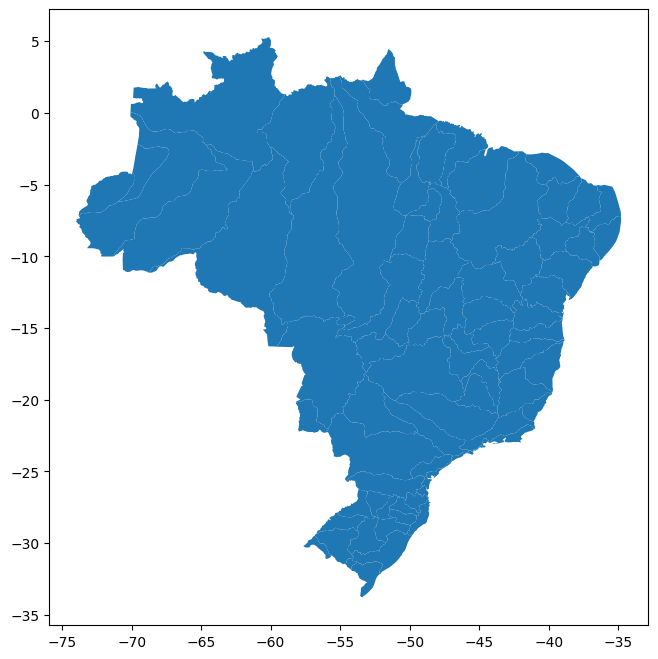

In [6]:
df_shape_sub_brasil.plot(figsize=(8,8))

In [7]:
# Filtro por sub-bacia
sb = int(input("Digite a Sub-bacia de interesse: "))
subbacia_select = df_shape_sub_brasil.loc[df_shape_sub_brasil.DNS_NU_SUB== sb ].to_crs(epsg='4326') #CONVERTE A GEOMETRIA PARA O SISTEMA MÉTRICO
subbacia_select

# Filtro por bacia
#b = int(input("Digite a Bacia de interesse: "))
#bacia_select = df_shape_sub_brasil.loc[df_shape_sub_brasil.DNS_DNB_CD== b ].to_crs(epsg='4326') #CONVERTE A GEOMETRIA PARA O SISTEMA MÉTRICO
#bacia_select

Digite a Sub-bacia de interesse: 76


,OBJECTID,DNS_DNB_CD,DNS_NU_SUB,DNS_NM,geometry
51,52,7,76,Ibicuí,"POLYGON ((-54.11611 -31.04006, -54.10779 -31.0..."


In [8]:
indice_selecionado = subbacia_select.index
name_bacia = subbacia_select.DNS_NM.to_list()
name_bacia = name_bacia[0]

Text(0.5, 1.0, 'Mapa da bacia Ibicuí')

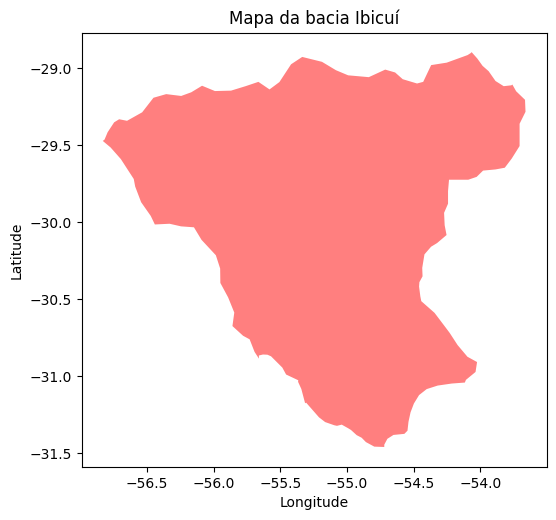

In [9]:
subbacia_select.plot(figsize=(6,6), legend='true', color= 'red', alpha = .5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Mapa da bacia %s'%name_bacia)

### Download metadados da ANA

In [10]:

# Importando dataframes de vazão e precipitação da ANA
meta_flow = download.metadata_ana_flow(folder='/content/Separacao_flow',)
meta_prec = download.metadata_ana_prec(folder='/content/Separacao_flow',)

# Importando DataFrames dos metadados
df_meta_flow = load.metadata_ana_flow(file=meta_flow)  # vazões
df_meta_prec = load.metadata_ana_prec(file=meta_prec)  # precipitação

print('Metadados de vazão')
print(df_meta_flow.head().to_string())
print()
print('Metadados de precipitação')
print(df_meta_prec.head().to_string())

#df_meta_flow.info() #informações do dataframe

Metadados de vazão
                   Name CodEstacao Type  DrainageArea  SubBasin  City State   Responsible  Latitude  Longitude  StartDate    EndDate  NYD    MD  N_YWOMD  YWMD
0                 BORJA   10064000    1      115000.0        10  PERU  PERU  SENAMHI-PERU   -4.4700   -77.5500 1986-02-02 2013-03-15   28  27.6       17  39.3
1             SAN REGIS   10070500    1      316000.0        10  PERU  PERU  SENAMHI-PERU   -4.5100   -73.9500 1994-05-16 2005-10-17   12   0.1       10  16.7
2               REQUENA   10074800    1        4738.0        10  PERU  PERU  SENAMHI-PERU   -5.0300   -73.8300 1984-10-25 2005-10-17   22   8.6       15  31.8
3           TAMISHIYACU   10075000    1        8985.0        10  PERU  PERU  SENAMHI-PERU   -4.0036   -73.1611 1983-10-02 2010-09-13   28   5.0       23  17.9
4  FRANCISCO DE ORELLAN   10080900    1           NaN        10  PERU  PERU  SENAMHI-PERU   -0.4731   -76.9825 2001-01-02 2005-10-29    5   0.1        3  40.0

Metadados de precipitação


#### Plotagem das estações

<Axes: >

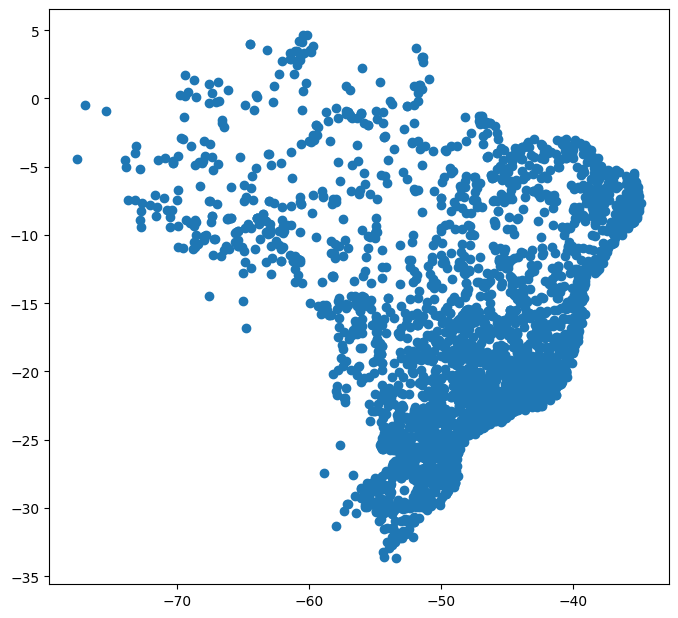

In [11]:

# Criando uma lista de geometrias no formato de ponto
pontos = [Point(x) for x in zip(df_meta_flow.Longitude,
                                df_meta_flow.Latitude)]
# Definindo o sistema de coordenadas
crs={'proj':'latlong','ellps':'WGS84','datum':'WGS84','no_def':True}

# Criando o geodataframe
df_meta_flow_geo = gpd.GeoDataFrame(df_meta_flow, geometry=pontos,crs=crs)

df_meta_flow_geo.plot(figsize=(8,8))

### Escolha de estação de vazão para separação de eventos

In [ ]:
df_meta_flow = df_meta_flow.astype({"CodEstacao": int}) # Transforma a coluna CodEstacao em int
flow_station = '76800000' # Estação de vazão selecionada para separação de eventos
#df = df_meta_flow[df_meta_flow.CodEstacao.isin(flow_station)] # Filtra Dataframe da estação de vazão selecionada
file_flow = download.ana_flow(code=flow_station, folder='/content/Separacao_flow') # Download da série de vazão

df_flow = pd.read_csv("/content/Separacao_flow/ANA-flow_76800000_1964-2023__by-2023-07-12.txt", sep=";") #Carregando série de vazão
df_flow

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_flow.Date, y=df_flow['Flow'], name="Vazão"))#,line_color='black'))
fig.layout.update(title_text='Série de vazão da estação selecionada',xaxis_rangeslider_visible=True)
fig

### Estações de precipitação para gerar IDW

In [37]:
stations_code_list = ['02850019','02854012','02855004','02953008','02953030','02954001','02954004','02954005','02954031','02955006','02955007','02955013',
                      '02955017','02956006','03053004','03053023','03053024','03053028','03054002','03054016','03054019','03054020','03054021','03055003',
                      '03056007','03154003','03154008','03155001']
print(stations_code_list)
print(len(stations_code_list))

['02850019', '02854012', '02855004', '02953008', '02953030', '02954001', '02954004', '02954005', '02954031', '02955006', '02955007', '02955013', '02955017', '02956006', '03053004', '03053023', '03053024', '03053028', '03054002', '03054016', '03054019', '03054020', '03054021', '03055003', '03056007', '03154003', '03154008', '03155001']
28


In [33]:
data_stations = hydrobr.get_data.ANA.prec_data(stations_code_list, only_consisted=False) #dados brutos

100%|██████████| 28/28 [02:35<00:00,  5.55s/it]


In [34]:
gantt_fig = hydrobr.Plot.gantt(data_stations) #Get the Gantt Fig

#Updating the layout
gantt_fig.update_layout(
    autosize=False,
    width=1200,
    height=500,
    xaxis_title = 'Year',
    yaxis_title = 'Station Code',
    font=dict(family="Courier New, monospace", size=12))

#To plot and save the gantt plot as html
plot(gantt_fig,filename='gantt' + '.html')

'gantt.html'

In [35]:
gantt_fig

In [38]:
df_meta_prec = df_meta_prec.astype({"CodEstacao": int}) # Transforma a coluna CodEstacao em int

!mkdir -p "/content/Separacao_flow/Estacoes_prec"

for j in range(len(stations_code_list)): #range coloca cada vez um codigo de estação na lista pro download
  file_prec = download.ana_prec(code= stations_code_list[j],folder='/content/Separacao_flow/Estacoes_prec')
  print('Arquivo salvo em: {}'.format(file_prec))

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02850019_2002-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:09<00:00,  9.46s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02854012_1976-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02855004_1978-2022__by-2023-07-13.txt


100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02953008_1943-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02953030_1976-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:23<00:00, 23.90s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02954001_1943-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:09<00:00,  9.99s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02954004_1959-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02954005_1966-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:16<00:00, 16.06s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02954031_1983-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:08<00:00,  8.14s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02955006_1969-2022__by-2023-07-13.txt


100%|██████████| 1/1 [00:06<00:00,  6.74s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02955007_1969-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:04<00:00,  4.67s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02955013_1986-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02955017_2004-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_02956006_1969-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03053004_1999-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03053023_2000-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03053024_2004-2022__by-2023-07-13.txt


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03053028_2009-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:13<00:00, 13.99s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03054002_1934-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:09<00:00,  9.16s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03054016_1976-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03054019_1999-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03054020_2004-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:03<00:00,  3.93s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03054021_2004-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:08<00:00,  8.44s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03055003_1976-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:08<00:00,  8.23s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03056007_1983-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:08<00:00,  8.02s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03154003_1976-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:03<00:00,  3.56s/it]


Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03154008_2000-2023__by-2023-07-13.txt


100%|██████████| 1/1 [00:08<00:00,  8.15s/it]

Arquivo salvo em: /content/Separacao_flow/Estacoes_prec/ANA-prec_03155001_1976-2023__by-2023-07-13.txt


# VERIFICAR A PARTIR DAQUI, GERAÇÂO DO DATAFRAME NAO ESTA CORRETA

In [43]:
import os
directory = "/content/Separacao_flow/Estacoes_prec/"

# Criar um DataFrame vazio
df = pd.DataFrame()

# Listar todos os arquivos TXT no diretório
txt_files = [file for file in os.listdir(directory) if file.endswith(".txt")]


In [46]:
for file in txt_files:
    # Construir o caminho completo para o arquivo TXT
    file_path = os.path.join(directory, file)

In [58]:

# Criar um DataFrame vazio com a coluna "Data"
df = pd.DataFrame(columns=["Data"])

# Iterar sobre os arquivos TXT
for file in txt_files:
    # Construir o caminho completo para o arquivo TXT
    file_path = os.path.join(directory, file)

    # Ler o arquivo TXT e criar um DataFrame temporário
    temp_df = pd.read_csv(file_path, sep="\t", names=["Data", file[:-4]])

    # Adicionar o DataFrame temporário ao DataFrame principal
    df = pd.merge(df, temp_df, on="Data", how="outer")

# Ordenar o DataFrame com base na coluna "Data"
df.sort_values("Data", inplace=True)

# Definir a coluna "Data" como índice
df.set_index("Data", inplace=True)

# Exibir o DataFrame resultante
df

,ANA-prec_03053028_2009-2023__by-2023-07-13,ANA-prec_02955006_1969-2022__by-2023-07-13,ANA-prec_02954004_1959-2023__by-2023-07-13,ANA-prec_03054021_2004-2023__by-2023-07-13,ANA-prec_03054002_1934-2023__by-2023-07-13,ANA-prec_03056007_1983-2023__by-2023-07-13,ANA-prec_02953008_1943-2023__by-2023-07-13,ANA-prec_03154003_1976-2023__by-2023-07-13,ANA-prec_02954031_1983-2023__by-2023-07-13,ANA-prec_02955007_1969-2023__by-2023-07-13,...,ANA-prec_03154008_2000-2023__by-2023-07-13,ANA-prec_03053023_2000-2023__by-2023-07-13,ANA-prec_02954001_1943-2023__by-2023-07-13,ANA-prec_03054019_1999-2023__by-2023-07-13,ANA-prec_02854012_1976-2023__by-2023-07-13,ANA-prec_02955013_1986-2023__by-2023-07-13,ANA-prec_03054016_1976-2023__by-2023-07-13,ANA-prec_02955017_2004-2023__by-2023-07-13,ANA-prec_03053024_2004-2022__by-2023-07-13,ANA-prec_02953030_1976-2023__by-2023-07-13
Data,,,,,,,,,,,,,,,,,,,,,
1934-01-01;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-02;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-03;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-04;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1934-01-05;10.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27;1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28;0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-28;0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
